# Combined network: 

- Encoder-decoder unit --> Local network with self-supervised learning --> mimic PV?

- Encoder-classifier unit --> Global network with supervised learning --> mimic SST?


TODO:
- find this SST input ?
- Quantify learning: ablation of specific inputs or total specific areas
- Drop off of some units in specific areas or layers for example

In [11]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from skimage.metrics import structural_similarity as ssim
import numpy as np

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Dataset

In [12]:
from dataset import get_mnist_dataset
working_directory = os.getcwd()
data_dir = os.path.join(working_directory, './dataset')
batch_size_train = 64
batch_size_test = 1000

train_data_loader, test_data_loader = get_mnist_dataset(data_dir, batch_size_train=batch_size_train, batch_size_test=batch_size_test)

print('Train dataset size: {}'.format(len(train_data_loader.dataset)))
print('Test dataset size: {}'.format(len(test_data_loader.dataset)))

Train dataset size: 60000
Test dataset size: 10000


### Model

In [85]:
from modules.network import PV_SST_Pyr

model = PV_SST_Pyr(thal_input_dim = 784, latent_dim=16, output_dim=10)

print(model)

PV_SST_Pyr(
  (encoder): encoder(
    (flatten): Flatten()
    (activation): Sigmoid()
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=16, bias=True)
  )
  (decoder): decoder(
    (activation): Sigmoid()
    (fc1): Linear(in_features=16, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=784, bias=True)
  )
  (classifier): classifier(
    (fc1): Linear(in_features=16, out_features=10, bias=True)
    (activation): Sigmoid()
  )
)


In [86]:
for name, param in model.named_parameters():
    print (name)   

encoder.fc1.weight
encoder.fc1.bias
encoder.fc2.weight
encoder.fc2.bias
encoder.fc3.weight
encoder.fc3.bias
decoder.fc1.weight
decoder.fc1.bias
decoder.fc2.weight
decoder.fc2.bias
classifier.fc1.weight
classifier.fc1.bias


### Train & test

In [87]:
from modules.utils import weight_update, print_grad_norms
lr = 0.05
momentum = 0.5
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

num_epochs = 10
log_interval = 300
alpha = 0.5 

train_losses = []
train_recon_losses = []
train_global_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

def train(epoch, dataloader, model, optimizer, loss_fn, alpha):
    recon_loss_avg = 0
    global_loss_avg = 0
    loss_avg = 0
    model.train() 
    for batch_idx, batch in enumerate(dataloader):
        optimizer.zero_grad()
        thal_input, target = batch 
        t = F.one_hot(target, num_classes=10).float()
        _, recon, output = model(thal_input)

        recon_loss = loss_fn(recon, thal_input.view(thal_input.size(0), -1)) 
        global_loss = loss_fn(output, t)
        total_loss = alpha*recon_loss + (1 - alpha)*global_loss
        recon_loss_avg += recon_loss.item()
        global_loss_avg += global_loss.item()
        loss_avg += total_loss.item()
        weight_update(model, optimizer, recon_loss, global_loss, total_loss)
        
        if batch_idx % log_interval == 0:
            train_losses.append(total_loss.item())
            train_recon_losses.append(recon_loss.item())
            train_global_losses.append(global_loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(dataloader.dataset)))
            #print_grad_norms(model.encoder, "Encoder")
            #print_grad_norms(model.decoder, "Decoder")
            #print_grad_norms(model.classifier, "Classifier")

    recon_loss_avg, global_loss_avg, loss_avg = (loss / len(dataloader) for loss in (recon_loss_avg, global_loss_avg, loss_avg))
    print('Epoch: {} Recon_loss: {:.6f} Global_loss: {:.6f}  Total loss: {:.6f}'.format(epoch, recon_loss_avg, global_loss_avg, loss_avg))

def test(dataloader, model, loss_fn, alpha):
    model.eval()
    recon_loss_avg = 0
    global_loss_avg = 0
    test_loss_avg = 0
    with torch.no_grad():
        for batch in dataloader:
            thal_input, target = batch
            t = F.one_hot(target, num_classes=10).float()
            _, recon, output = model(thal_input)

            recon_loss = loss_fn(recon, thal_input.view(thal_input.size(0), -1))
            global_loss = loss_fn(output, t)
            total_loss = alpha*recon_loss + (1 - alpha)*global_loss
            recon_loss_avg += recon_loss.item()
            global_loss_avg += global_loss.item()
            test_loss_avg += total_loss.item()
            #ssim_score = calculate_ssim(recon, inputs)
            
    recon_loss_avg, global_loss_avg, test_loss_avg = (loss / len(dataloader) for loss in (recon_loss_avg, global_loss_avg, test_loss_avg))
    test_losses.append(test_loss_avg)
    print('Test set: Recon_loss: {:.6f} Global_loss: {:.6f} Total loss: {:.6f}\n'.format(recon_loss_avg, global_loss_avg, test_loss_avg))
    


In [88]:
test(test_data_loader, model, loss_fn, alpha)

for epoch in range(1, num_epochs + 1):
  train(epoch, train_data_loader, model, optimizer, loss_fn, alpha)
  test(test_data_loader, model, loss_fn, alpha)

Test set: Recon_loss: 1.274092 Global_loss: 0.259917 Total loss: 0.767004

Epoch: 1 Recon_loss: 1.071284 Global_loss: 0.106241  Total loss: 0.588762
Test set: Recon_loss: 0.945693 Global_loss: 0.090108 Total loss: 0.517900

Epoch: 2 Recon_loss: 0.887022 Global_loss: 0.089995  Total loss: 0.488509
Test set: Recon_loss: 0.859567 Global_loss: 0.089998 Total loss: 0.474783

Epoch: 3 Recon_loss: 0.840284 Global_loss: 0.090010  Total loss: 0.465147
Test set: Recon_loss: 0.834962 Global_loss: 0.090000 Total loss: 0.462481

Epoch: 4 Recon_loss: 0.824906 Global_loss: 0.089992  Total loss: 0.457449
Test set: Recon_loss: 0.825020 Global_loss: 0.089976 Total loss: 0.457498

Epoch: 5 Recon_loss: 0.818005 Global_loss: 0.089976  Total loss: 0.453990
Test set: Recon_loss: 0.819909 Global_loss: 0.089967 Total loss: 0.454938

Epoch: 6 Recon_loss: 0.814162 Global_loss: 0.089970  Total loss: 0.452066
Test set: Recon_loss: 0.816875 Global_loss: 0.089962 Total loss: 0.453419

Epoch: 7 Recon_loss: 0.811779 G

In [52]:
# Tester avec une recon_loss = 0, une fois avec global_loss = 0, une fois avec total_loss = 0
# recon_loss = 0 -> decoder ne doit pas être mis à jour mais encoder ok -> recon_test_loss haute, global et total loss basse
# global_loss = 0 -> classifier ne doit pas être mis à jour mais encoder et decoder ok -> global_test_loss haute, recon et total loss basse
# total_loss = 0 -> encoder ne doit pas être mis à jour mais classifier et decoder ok -> recon et global loss hautes

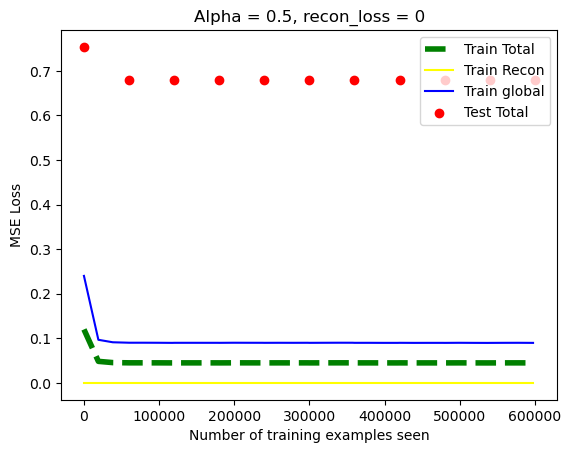

In [61]:
# recon_loss = 0 -> decoder ne doit pas être mis à jour mais encoder ok -> recon_test_loss haute, global et total loss basse
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='green', linestyle= 'dashed', linewidth = 4)
plt.plot(train_counter, train_recon_losses, color='yellow')
plt.plot(train_counter, train_global_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Total', 'Train Recon', 'Train global', 'Test Total'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylabel('MSE Loss')
plt.title("Alpha = 0.5, recon_loss = 0")
plt.savefig('Alpha=0.5,recon_loss=0.png', dpi=300, bbox_inches='tight')
plt.show()